In [46]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# ML Model Creation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics

import statsmodels.api as sm

RANDOM_SEED = 42

current_dir = os.getcwd()
data_fldr = os.path.join(current_dir, "..", "data")
out_dir = os.path.join(current_dir, "..", "data", "output")
# print(current_dir)

# Datasets

In [2]:
coe_df = pd.read_excel(os.path.join(data_fldr, "COE_Export.xlsx"), sheet_name="Yearly")
cpi_df = pd.read_excel(os.path.join(data_fldr, "ConsumerPriceIndex.xlsx"), sheet_name="Consolidate")
ni_df = pd.read_excel(os.path.join(data_fldr, "NationalIncome.xlsx"), sheet_name="Consolidate")
hh_df = pd.read_excel(os.path.join(data_fldr, "Household.xlsx"), sheet_name="Consolidate")
ms_df = pd.read_excel(os.path.join(data_fldr, "MaritalStatus.xlsx"), sheet_name="Consolidate")
pp_df = pd.read_excel(os.path.join(data_fldr, "Population.xlsx"), sheet_name="Consolidate")


In [3]:
# coe_df
# cpi_df

## Choosing of COE Category

In [4]:
coe_cat_df = coe_df.loc[coe_df['Category'] == "A", :]
coe_cat_df

,Year,Category,Value
0,2000,A,38981.083333
5,2001,A,27031.791667
10,2002,A,30831.916667
15,2003,A,28754.875000
20,2004,A,25180.916667
25,2005,A,16550.791667
30,2006,A,11187.166667
35,2007,A,14101.125000
40,2008,A,12330.291667
45,2009,A,11600.041667


## Joining of Datasets

### Full Dataframe

In [18]:
# List of DataFrames
dfs = [coe_cat_df, cpi_df, ni_df, hh_df, ms_df, pp_df]

# Merge DataFrames using functools.reduce()
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Year', how='left'), dfs)
merged_df

,Year,Category,Value,MAS Core Inflation Measure (Index),Residential Properties Price Index,Landed Price Index,Non-Landed Price Index,Per Capita GDP (Dollar),HDB 1- And 2-Room Flats,HDB 3-Room Flats,...,Total Female Malays,Total Chinese,Total Male Chinese,Total Female Chinese,Total Indians,Total Male Indians,Total Female Indians,Total Other Ethnic Groups,Total Males Other Ethnic Groups,Total Females Other Ethnic Groups
0,2000,A,38981.083333,73.818,97.950,99.350,97.700,41121.0,45600.0,235700.0,...,226357.0,2513847.0,1249662.0,1264185.0,257866.0,134337.0,123529.0,46443.0,21818.0,24625.0
1,2001,A,27031.791667,74.965,88.200,90.575,87.450,38880.0,41800.0,233400.0,...,229818.0,2552077.0,1267019.0,1285058.0,262968.0,136485.0,126483.0,49069.0,23084.0,25985.0
2,2002,A,30831.916667,74.927,82.475,85.225,81.575,39679.0,41400.0,225300.0,...,233284.0,2589525.0,1283362.0,1306163.0,271923.0,140768.0,131155.0,53136.0,25089.0,28047.0
3,2003,A,28754.875000,75.631,81.000,83.625,80.150,41343.0,44200.0,225800.0,...,234194.0,2572607.0,1273256.0,1299351.0,269899.0,138642.0,131257.0,54594.0,25906.0,28688.0
4,2004,A,25180.916667,77.135,80.675,83.150,79.975,46664.0,41200.0,224700.0,...,237453.0,2599813.0,1285557.0,1314256.0,278106.0,142754.0,135352.0,59658.0,28484.0,31174.0
5,2005,A,16550.791667,78.104,83.000,84.625,82.700,49867.0,44500.0,211600.0,...,240316.0,2626723.0,1297849.0,1328874.0,291131.0,149621.0,141510.0,69238.0,33263.0,35975.0
6,2006,A,11187.166667,79.445,88.950,88.875,89.175,53655.0,46200.0,229300.0,...,243219.0,2656358.0,1310873.0,1345485.0,303096.0,155938.0,147158.0,80462.0,38672.0,41790.0
7,2007,A,14101.125000,81.195,109.925,103.850,111.575,59429.0,44700.0,221300.0,...,245583.0,2686997.0,1324715.0,1362282.0,313395.0,161484.0,151911.0,92138.0,44309.0,47829.0
8,2008,A,12330.291667,85.802,123.475,115.175,125.400,56607.0,43000.0,223200.0,...,248093.0,2721779.0,1339596.0,1382183.0,323431.0,167149.0,156282.0,102339.0,49230.0,53109.0
9,2009,A,11600.041667,85.783,106.000,105.850,106.050,56619.0,49700.0,226500.0,...,250936.0,2770303.0,1360224.0,1410079.0,343509.0,178129.0,165380.0,120013.0,57264.0,62749.0


In [21]:
df = merged_df.drop(columns=['Category']).drop([24]).set_index('Year')

# Machine Learning Portion

In [22]:
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=f_regression, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [23]:
def log_scale(X):
    return np.log1p(X)

In [24]:
# Initialize FunctionTransformer
transformer = FunctionTransformer(log_scale)

In [73]:
# Step 4: Split your data into training and testing sets
X = df.drop('Value', axis=1)  # Features
y = df['Value']  # Target variable

# Calculate the number of rows that correspond to 10% of the dataset
test_size = int(len(X) * 0.20)

# Splitting the data into training and testing sets manually
X_train = X.iloc[:-test_size, :]
X_test = X.iloc[-test_size:, :]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

X_train_log_scaled = transformer.transform(X_train)
# Add a constant to the X_train_log_scaled for the intercept term
X_train_log_scaled_with_const = sm.add_constant(X_train_log_scaled)


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Feature Selection

In [56]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# Scores for features & Offset 1 cause Target Feature
feature_df = pd.DataFrame({"Features": df.columns[1:], "Scores": fs.scores_})
topN = 5
topN_features = feature_df.sort_values('Scores', ascending=False)[:topN]
topN_features
# print(fs.pvalues_)

,Features,Scores
2,Landed Price Index,25.902674
1,Residential Properties Price Index,14.826662
3,Non-Landed Price Index,12.062089
0,MAS Core Inflation Measure (Index),7.105569
12,Single,6.600198


In [62]:
topN_features_names = list(topN_features.loc[:, 'Features'])
X_train_topN, X_test_topN = X_train.loc[:, topN_features_names], X_test.loc[:, topN_features_names]
# X_train_topN 
# X_test_topN

,Landed Price Index,Residential Properties Price Index,Non-Landed Price Index,MAS Core Inflation Measure (Index),Single
Year,,,,,
2020,172.750,153.875,149.725,99.845,1090700.0
2021,189.200,166.150,161.050,100.769,1063300.0
2022,211.825,183.025,176.375,104.918,997800.0
2023,229.000,196.675,189.125,109.274,1056000.0


In [76]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)

param_grid_forest = {
    'n_estimators': [200,400, 700],
    'max_depth': [10,20,30],
    'criterion' : ["mse"],
    'max_leaf_nodes': [50, 100]
}

grid_forest = GridSearchCV(
        estimator=rf,
        param_grid=param_grid_forest, 
        cv=5, 
        n_jobs=-1, 
        scoring='neg_mean_squared_error',
        verbose=0
    )



In [78]:
model_forest = grid_forest.fit(X_train, y_train)

pred = model_forest.predict(X_test)
mse = metrics.mean_squared_error(y_test, pred)
mae = metrics.mean_absolute_error(y_test, pred)
r2 = metrics.r2_score(y_test, pred)

print(mse)
print(mae)
print(r2)

367219719.0414816
15608.678211805567
0.3207473444672826


In [79]:
model_forest_fs = grid_forest.fit(X_train_topN, y_train)

pred_topN = model_forest.predict(X_test_topN)
mse_topN = metrics.mean_squared_error(y_test, pred_topN)
mae_topN = metrics.mean_absolute_error(y_test, pred_topN)
r2_topN = metrics.r2_score(y_test, pred_topN)

print(mse_topN)
print(mae_topN)
print(r2_topN)

573173452.5987484
21416.861467013878
-0.06020883294281054


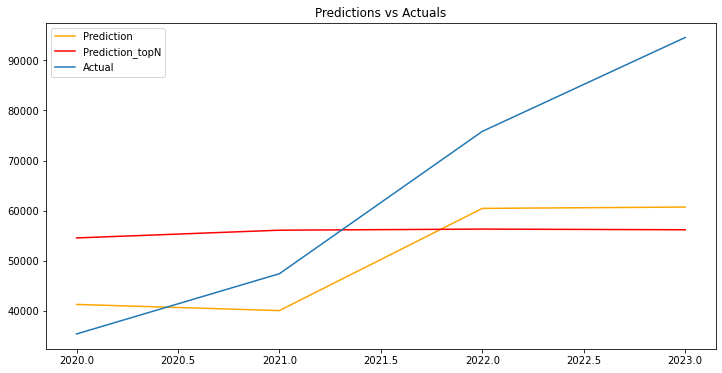

In [81]:
plt.figure(figsize=(12,6), facecolor='white')
plt.plot(X_test.index, pred, label='Prediction', color='Orange')
plt.plot(X_test.index, pred_topN, label='Prediction_topN', color='Red')
plt.plot(X_test.index, y_test, label='Actual')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()